**Стартап по продаже продуктов питания**
Необходимо понять как ведут себя пользователи мобильного приложения. 

**Цель исследования** — понять как ведут себя пользователи мобильного приложения

**Ход исследования**

Данные для исследования находятся датасете:  
'/datasets/logs_exp.csv' - здесь находится вся информация о событиях или действии пользователя  

*Описание данных*

EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
 
В рамках исследования необходимо будет сначала провести подготовку данных. Далее изучить воронку продаж и узнать, как пользователи доходят до покупки. После этого исследовать результаты A/A/B-эксперимента. В рамках этого исследования изучим воронку событий, в каком порядке происходят события, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем), акая доля пользователей доходит от первого события до оплаты и т.д. Также изучим находят ли статистические критерии разницу между выборками. Сделаем основные выводы по шрифтам и выберем "победную" выборку. 

Таким образом, исследование пройдёт в 3 этапа:
 1. Подготовка данных.
 2. Проведение анализа А/А/В теста.
 3. Сделаем итоговые выводы.

In [ ]:
# загрузим необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth

## Начнем подготовку данных

In [ ]:
# данные были склеены, пришлось разделение сделать
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [ ]:
logs.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [ ]:
logs.columns = ['event_name', 'user_id', 'event_time', 'experiment_id']

In [ ]:
# посмотрим на пропуски и типы данных
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   user_id        244126 non-null  int64 
 2   event_time     244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
# пропусков нет, создадим столбец с датами и времени
logs['datetime'] = pd.to_datetime(logs['event_time'], unit='s')

In [ ]:
logs.head(4)

,event_name,user_id,event_time,experiment_id,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47


In [ ]:
# создадим отдельный столбец с датами и приведем в нужный тип
logs['date'] = logs['datetime'].dt.date
logs['date'] = logs['date'].astype('datetime64[ns]')

In [ ]:
logs.head(4)

,event_name,user_id,event_time,experiment_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25


In [ ]:
# еще проверим на дубликаты данные
logs.duplicated().sum()

413

In [ ]:
# посмотрим дубликаты 
logs[logs.duplicated() == True].sort_values(by='user_id').head(50)

,event_name,user_id,event_time,experiment_id,datetime,date
130558,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-04
130995,OffersScreenAppear,33176906322804559,1564933763,248,2019-08-04 15:49:23,2019-08-04
104108,CartScreenAppear,34565258828294726,1564857221,248,2019-08-03 18:33:41,2019-08-03
159302,PaymentScreenSuccessful,54903596035630984,1565011672,248,2019-08-05 13:27:52,2019-08-05
176813,PaymentScreenSuccessful,77364241990273403,1565044732,246,2019-08-05 22:38:52,2019-08-05
189896,MainScreenAppear,91292479590032512,1565087723,246,2019-08-06 10:35:23,2019-08-06
155464,MainScreenAppear,95206628315371849,1565005724,247,2019-08-05 11:48:44,2019-08-05
110479,MainScreenAppear,170935625628929269,1564897487,246,2019-08-04 05:44:47,2019-08-04
34223,CartScreenAppear,197027893265565660,1564684544,246,2019-08-01 18:35:44,2019-08-01
17037,CartScreenAppear,197027893265565660,1564659614,246,2019-08-01 11:40:14,2019-08-01


In [ ]:
# судя по таблице здесь встречаются явные дубликаты , причем повторяются даже по 6 раз. Я предлагаю удалить дубликаты
logs = logs.drop_duplicates().reset_index()

**Вывод**  
Мы провели основную предобработку данных и подготовили таблицу к дальнейшим исследованиям.  
В рамках предобработки датафрейм был приведен в визуально пригодный вид. Были замененые наименования столбцов, добавлены столбцы с датами и временем, также приведены типы в соответствие. Дополнительно проверили на пропуски и избавились от дубликатов.

## Проведем анализ А/А/В теста

In [ ]:
# посчитаем количество событий в логе
logs['event_name'].count()

243713

In [ ]:
# посчитаем сколько всего пользователей в логе: 
logs['user_id'].nunique()

7551

In [ ]:
# количество событий в среднем на пользователя
event_mean = logs['event_name'].count()/logs['user_id'].nunique()
round(event_mean, 0)

32.0

In [ ]:
# находим максимальную и минимальную дату
print('Максимальная дата:', logs['date'].max())
print('Минимальная дата:', logs['date'].min())

Максимальная дата: 2019-08-07 00:00:00
Минимальная дата: 2019-07-25 00:00:00


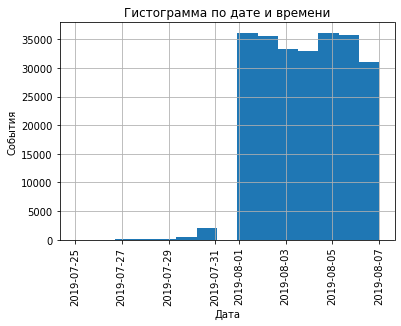

In [ ]:
# построим гистограмму по дате и времени для анализа полноты данных
logs['date'].hist(bins=15).set_title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('События')
plt.xticks(rotation=90) 
plt.show()

In [ ]:
logs.head()

,index,event_name,user_id,event_time,experiment_id,datetime,date
0,0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


**Краткий вывод**  
Исходя из графика можно сделать вывод, что видимо "доезжают" данные к 1.08.2019 и с этой даты данные полные. Я хочу отбросить данные с минимальной даты (25.07.2019) и до 1.08.2019. Здесь уже видно, что на самом деле я располагаю данными за период с 1.08.2019 по 7.08.2019. 

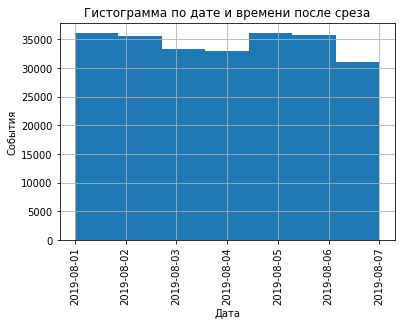

In [ ]:
# отсекаю период до 1.08.2019 и строю новую гистограмму
logs_query_date = logs.query('date > "2019-07-31"')
logs_query_date['date'].hist(bins=7).set_title('Гистограмма по дате и времени после среза')
plt.xlabel('Дата')
plt.ylabel('События')
plt.xticks(rotation=90) 
plt.show()

**Краткий вывод**  
Здесь уже одноуровневое распределение получилось, и гистограмма подтвердила мою мысль, что я на самом деле располагаю данными за период с 1.08.2019 по 7.08.2019. 

In [ ]:
# посчитаем сколько событий и пользователей потеряли после среза
print('Количество событий:', logs['date'].count() - logs_query_date['date'].count())

Количество событий: 2826


In [ ]:
print('Количество пользователей:', logs['user_id'].nunique() - logs_query_date['user_id'].nunique())

Количество пользователей: 17


In [ ]:
# посчитаем это в % соотношении от наших данных в части событий: 
share_events = round(100 - (logs_query_date['date'].count() / logs['date'].count() * 100),2)
print('Процент событий, которые мы удалили, от наших данных:', share_events, '%')

Процент событий, которые мы удалили, от наших данных: 1.16 %


In [ ]:
# посчитаем это в % соотношении от наших данных в части пользователей: 
share_users = round(100 - (len(logs_query_date['user_id'].unique()) / len(logs['user_id'].unique()) * 100),2)
print('Процент пользователей, которых мы удалили, от наших данных:', share_users, '%')

Процент пользователей, которых мы удалили, от наших данных: 0.23 %


In [ ]:
# проверим наличие пользователей в группах
logs_query_date['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

In [ ]:
logs_query_date.groupby('experiment_id')['user_id'].nunique()

experiment_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Пользователей в каждой группе по 2.5 тысячи (разница между ними не значительна) 

**Краткий вывод**  
Мы провели не большой анализ по датам, определили временной период, в котором располагаются "полные" данные (с 1.08.2019 по 7.08.2019)отбросили период с не полными данными (с 25.07.2019 до 1.08.2019) Определили, что отбросив период с 25.07.2019 до 1.08.2019 мы потеряли 2826 событий и 17 пользователей. После проверки наличия пользователяй в наблюдаемых группах, мы можем далее продолжать исследование.

### Изучим воронку событий

In [ ]:
logs = logs_query_date

In [ ]:
logs.head(5)

,index,event_name,user_id,event_time,experiment_id,datetime,date
2826,2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [ ]:
# посчитаем события по наименованию и отсортируем
logs['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [ ]:
# считаем количество пользователей совершивших хотя бы одно событие и их долю
user_events = (logs.groupby('event_name').agg({'event_name' : 'count', 'user_id' : 'nunique'})
                                         .sort_values(by = 'user_id', ascending=False))
user_events['share_%'] = round((user_events['user_id'] / logs['user_id'].nunique() * 100), 2)
user_events.columns = ['event_count', 'user_id', 'share_%']
user_events = user_events.reset_index()
user_events

,event_name,event_count,user_id,share_%
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Первоначально я переведу события:  
MainScreenAppear - На главный экран  
OffersScreenAppear - Предложение  
CartScreenAppear - Корзина  
PaymentScreenSuccessful	- Оплата  
Tutorial - Обучение  
Воронка в целом так и выстраивается: сначала пользователь идет на главный экран (MainScreenAppear), далее выбирает товар (OffersScreenAppear) и после идет в корзину (CartScreenAppear). Там он совершает оплату (PaymentScreenSuccessful). Выше в нашей табличке отсортированной по пользователям как раз и выстраивается классическая воронка продаж. Выбивается только шаг "обучение", обычно он является первым шагом и тогда по идее должно быть там самое большое количество пользователей, но думаю обучение не является обязательным шагом и его многие пропускают. 

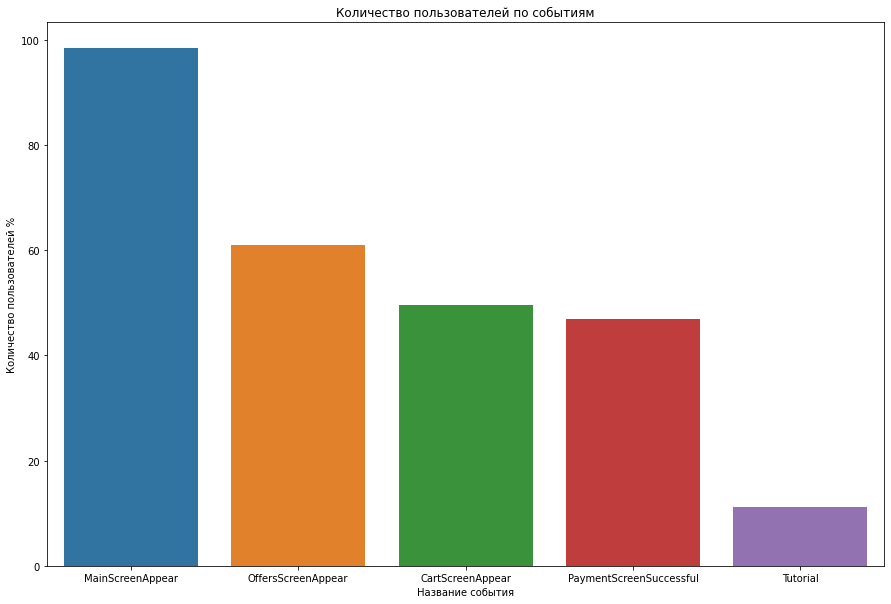

In [ ]:
# визуализируем мой вывод и подтвердим ненужность данных в событии "Tutorial"
event_grafic = user_events.pivot_table(index='event_name', values='share_%', aggfunc='sum').sort_values(
    by='share_%', ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=event_grafic.index,y=event_grafic['share_%'])
plt.title('Количество пользователей по событиям')
plt.xlabel('Название события')
plt.ylabel('Количество пользователей %')
plt.show()

Предыдущий мой вывод подтвердился, я думаю что можно убрать событие "Tutorial" для построения воронки событий с долями пользователя перешедших из каждого этапа.

In [ ]:
# посчитаем конверсию каждого шага в воронке, но перед этим избавимся от события "Tutorial"
user_events = user_events.iloc[:-1, :]
user_events['conversion'] = 0
for i in range(0, len(user_events['share_%'])):
    if i == 0:
        user_events['conversion'].iloc[i] = 100
    else:
        user_events['conversion'].iloc[i] = round(int(user_events['user_id'].iloc[i])
                                                  / int(user_events['user_id'].iloc[i-1]), 2)*100
user_events


/tmp/ipykernel_63/38324791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_events['conversion'] = 0
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,event_name,event_count,user_id,share_%,conversion
0,MainScreenAppear,117328,7419,98.47,100
1,OffersScreenAppear,46333,4593,60.96,62
2,CartScreenAppear,42303,3734,49.56,81
3,PaymentScreenSuccessful,33918,3539,46.97,95


In [ ]:
# еще на основе таблицы построим визуализацию: 
fig = go.Figure(go.Funnel(x = user_events['conversion'],
                          y = user_events['event_name'],
                          textinfo = 'percent initial',
                          hoverinfo = 'percent initial'))
fig.update_layout(title='Воронка событий с конверсией каждого шага')
fig.show();

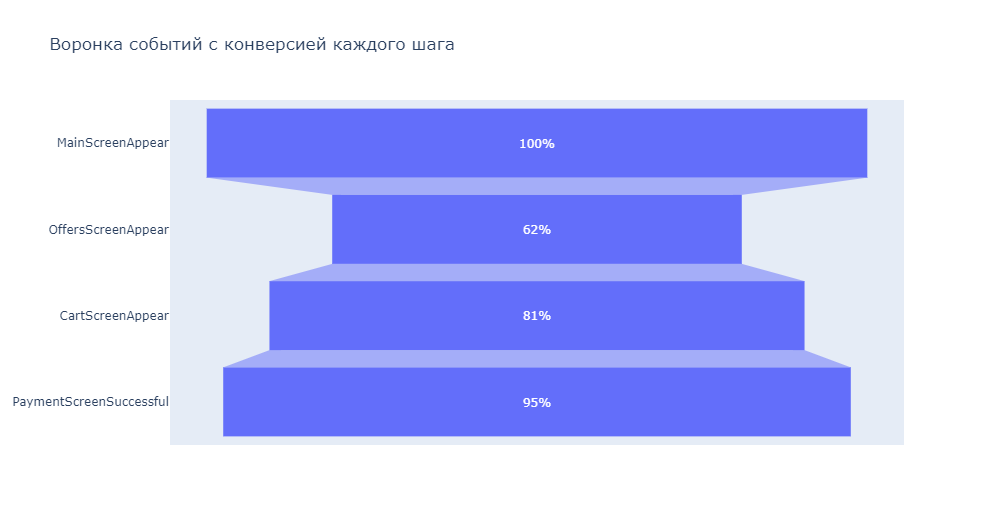

In [ ]:
# и построим такую же воронку для наглядности по конверсии с первого шага до оплаты
fig = go.Figure(go.Funnel(x = user_events['share_%'], 
                          y = user_events['event_name'],
                          hoverinfo = 'x'))
                          
fig.update_layout(title='Воронка событий с показателем конверсии от начального шага')
fig.show();

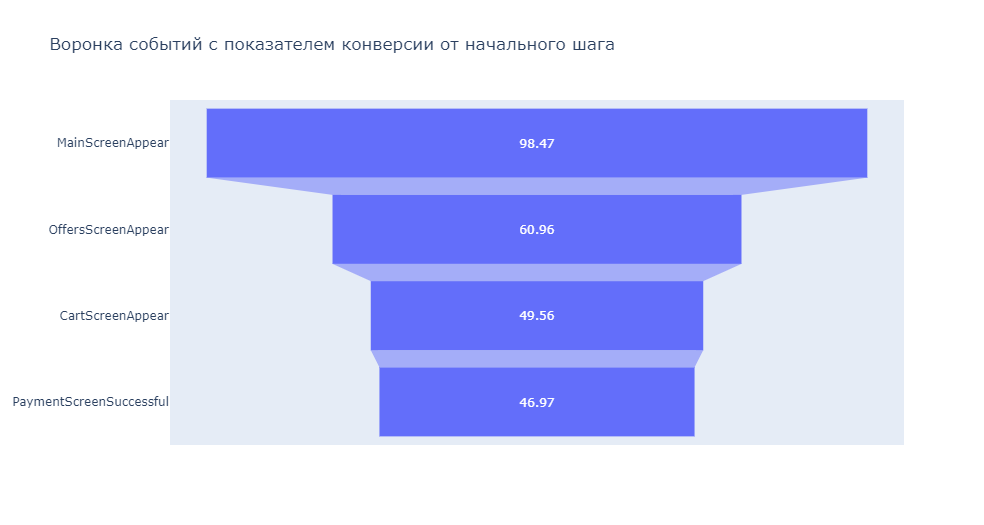

**Вывод**
Мы расчитали конверсию с этапа когда пользователи открывают главную страницу и до оплаты, а также отношения последующего этапа к предыдущему. Построили визуализацию по воронкам событий. Что мы увидели :  
1. можно избавится от события "Tutorial" по причине того, что вероятнее всего это не обязательный шаг, очень мало пользователей на него заходит. И соответствеено их действия не взаимосвязаны с дальнейшей покупкой.  
2. На этапе выбора товара "OffersScreenAppear" заметна достаточно большая просадка по пользователям - 38%. Получается только 62% от всех тех кто зашел в приложение доходят до выбора товара. Остальные просто возможно пролистывают и уходят.  
3. Если рассмотреть событийную воронку от этапа захода на главную страницу приложения и до покупки, то мы видим, что 46,97% пользователей которые пришли в приложение дошли до оплаты. Это почти половина, с учетом того что 38% теряются на этапе перехода выбора товара, выглядит достаточно не плохо.
-- Рекомендация отделу маркетинга -- стоит на этапе захода пользователя поработать над каким-либо предложением или всплывающим окном для увеличения заинтересованности пользователя и перехода его в следующий этап. Также возможно нужно поработать над товарной номенклатурой (послкольку возможно пользователь просто не находит то, что ему нужно). Дополнительно можно обратится к разработчикам и попросить проанализировать с технической стороны этот этап. Возможно есть технические сложности или ошибки, которые мешают пользователям перейти на следующий этап.
Далее конверсия от этапа к этапу увеличивается и дает нам 95% всех тех пользователей кто добавил в корзину товар перейти к оплате.  

### Изучим результаты эксперимента

In [ ]:
logs.head()

,index,event_name,user_id,event_time,experiment_id,datetime,date
2826,2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [ ]:
# посмотрим сколько пользователей в группах: 
users_group = logs.groupby('experiment_id')['user_id'].nunique()
users_group[249] = users_group[246] + users_group[247]
users_group

experiment_id
246    2484
247    2513
248    2537
249    4997
Name: user_id, dtype: int64

Разбивка можно сказать равная, пользователи между группами распределены почти одинаково. 

In [ ]:
# перед тем как провести тест , создам сводную таблицу расчитаю самое популярное событие и доли пользователей
test_group = logs[logs['event_name']!='Tutorial'].pivot_table(index='event_name', 
                                                         columns='experiment_id', 
                                                         values='user_id',
                                                         aggfunc='nunique').reset_index().sort_values(by=246, ascending=False)
test_group[249] = test_group[246] + test_group[247]
test_group['Total'] = test_group[248] + test_group[249]

test_group['portion_246'] = round((test_group[246] / users_group[246] * 100),1)
test_group['portion_247'] = round((test_group[247] / users_group[247] * 100),1)
test_group['portion_248'] = round((test_group[248] / users_group[248] * 100),1)
test_group['portion_249'] = round((test_group[249] / users_group[249]  * 100),1)
test_group

experiment_id,event_name,246,247,248,249,Total,portion_246,portion_247,portion_248,portion_249
1,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
2,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
0,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


**Краткий вывод**  
Самое популярное событие - это MainScreenAppear	(нахождение на главном экране). Что собственно и логично, потому что любое действие начинается почти всегда с захода на главную страницу или экран. 
Всего среди групп это событие собрало - 7419 пользователей , если разделить по группам :  
1. 246 - 2450  
2. 247 - 2476  
3. 248 - 2493  
Доля у события MainScreenAppear составила по группам:  
1. 246 - 98,6  
2. 247 - 98,5  
3. 248 - 98,3  

In [ ]:
# теперь напишем функцию для проведения z-test : 
def z_test(experiment_id1, experiment_id2, alpha):
    for i in test_group.index:
        p1 = test_group[experiment_id1][i] / users_group[experiment_id1]
        p2 = test_group[experiment_id2][i] / users_group[experiment_id2]
        p_combined = ((test_group[experiment_id1][i] + test_group[experiment_id2][i]) / 
                 (users_group[experiment_id1] + users_group[experiment_id2]))
        
        difference = p1 - p2
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_group[experiment_id1] + 1/users_group[experiment_id2]))
        
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-значение: {}'.format(test_group['event_name'][i], p_value))
        if (p_value < alpha):
            print("Нулевую гипотезу нужно отвергнуть: между долями есть статистически значимая разница")
        else:
            print("Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет")
        print('')

###### Прежде чем провести первые тесты, сформулируем гипотезы:  
###### Н0: Статистической значимой разницы между группами нет
###### Н1: Различия между группами статистически значимы 

In [ ]:
# проведем для проверки А/А тест (246/247 группы)
z_test(246,247,0.01)

MainScreenAppear p-значение: 0.7570597232046099
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

OffersScreenAppear p-значение: 0.2480954578522181
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

CartScreenAppear p-значение: 0.22883372237997213
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

PaymentScreenSuccessful p-значение: 0.11456679313141849
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет



Здесь нулевую гипотезу не получилось отвергнуть, по всем событиям статистически значимых различий нет. Также далее я буду везде применять уровень alpha = 0.05, т.к. он наиболее распространенный и применяется при проведении А/В теста (при проведении А/А теста допускается уровень значимости = 0.01). Перейдем к следующему тесту

In [ ]:
# Теперь проводим А/В тест (246/248 группы)
z_test(246,248,0.05)

MainScreenAppear p-значение: 0.2949721933554552
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

OffersScreenAppear p-значение: 0.20836205402738917
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

CartScreenAppear p-значение: 0.07842923237520116
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

PaymentScreenSuccessful p-значение: 0.2122553275697796
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет



In [ ]:
# 247/248
z_test(247,248,0.05)

MainScreenAppear p-значение: 0.4587053616621515
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

OffersScreenAppear p-значение: 0.9197817830592261
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

CartScreenAppear p-значение: 0.5786197879539783
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

PaymentScreenSuccessful p-значение: 0.7373415053803964
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет



In [ ]:
# 249/248
z_test(249,248,0.05)

MainScreenAppear p-значение: 0.29424526837179577
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

OffersScreenAppear p-значение: 0.43425549655188256
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

CartScreenAppear p-значение: 0.18175875284404386
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет

PaymentScreenSuccessful p-значение: 0.6004294282308704
Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет



## Вывод: 
Итак, было проведено исследование по выявлению поведения пользователей мобильного приложения по продаже продуктов питания.  
Первоначально была осуществлена подготовка данных, были заменены названия столбцов, данные проверены на пропуски и дубликаты, в ходе которой былы выявлены явные дубликаты и удалены, привели типы данных в соответствие и создали дополнительные два столбца с датами.  
В ходе изучения данных было определено 243713 событий в логе и 7551 пользователь в логе. В среднем приходится по 32 события на пользователя.  
Также для определения периода выявлена минимальная дата - 25.07.2019 и максимальная дата - 7.08.2019. По причине того, что в промежуток с 25.07.2019 до 1.08.2019 данные были не полные был определен временной период, в котором располагаются "полные" данные (с 1.08.2019 по 7.08.2019) и был отброшен период с не полными данными (с 25.07.2019 до 1.08.2019). После совершения действия мы потеряли 2826 событий и 17 пользователей.  
После всех вышеуказанных действий уже можно перейти к воронке событий. Воронка выстраивается следующим образом:  
1. сначала пользователь идет на главный экран (MainScreenAppear). Это самое популярное событие (нахождение на главном экране). Что собственно и логично, потому что любое действие начинается почти всегда с захода на главную страницу или экран. Всего среди групп это событие собрало - 7419 пользователей 
2. далее выбирает товар (OffersScreenAppear)  
3. после идет в корзину (CartScreenAppear)  
4. Там он совершает оплату (PaymentScreenSuccessful).  

Выбивается в воронке событий только шаг "обучение", обычно он является первым шагом и тогда по идее должно быть там самое большое количество пользователей, но думаю обучение не является обязательным шагом и его многие пропускают.  
По итогу была рассчитана конверсия с этапа когда пользователи открывают главную страницу и до оплаты, а также отношения последующего этапа к предыдущему. Построили визуализацию по воронкам событий. К каким мини-выводам это привело :  - Можно избавится от события "Tutorial" по причине того, что вероятнее всего это не обязательный шаг, очень мало пользователей на него заходит. И соответствеено их действия не взаимосвязаны с дальнейшей покупкой.  
- На этапе выбора товара "OffersScreenAppear" заметна достаточно большая просадка по пользователям - 38%. Получается только 62% от всех тех кто зашел в приложение доходят до выбора товара. Остальные просто возможно пролистывают и уходят.  
- Если рассмотреть событийную воронку от этапа захода на главную страницу приложения и до покупки, то мы видим, что 46,97% пользователей которые пришли в приложение дошли до оплаты. Это почти половина, с учетом того что 38% теряются на этапе перехода выбора товара, выглядит достаточно не плохо.
По итогу были составлены следующие рекомендации отделу маркетинга - стоит на этапе захода пользователя поработать над каким-либо предложением или всплывающим окном для увеличения заинтересованности пользователя и перехода его в следующий этап. Также возможно нужно поработать над товарной номенклатурой (послкольку возможно пользователь просто не находит то, что ему нужно). Дополнительно можно обратится к разработчикам и попросить проанализировать с технической стороны этот этап. Возможно есть технические сложности или ошибки, которые мешают пользователям перейти на следующий этап. Далее конверсия от этапа к этапу увеличивается и дает 95% всех тех пользователей кто добавил в корзину товар перейти к оплате.  

Наконец перешли к А/В тесту и проведению анализа его результата.  
Во первых была проведена проверка выборок, которая показала что количество пользователей почти равно между выборками.  
Далее проведен z-тест для выявления статистически значимого различия между двумя контрольными группами (А/А тест 246/247 группа) с уровнем статистической значимости в 0.01. Он такой маленький , потому что априори группы по идее одинаковы и чтобы уменьшить вероятность ошибки был снижен и уровень статистической значимости. Тест показал, что статистически значимой разницы нет.  
Далее сформулировав гипотезы :  
**Н0:** Статистической значимой разницы между группами нет  
**Н1:** Различия между группами статистически значимы  
Был проведен А/В тест с 16 проверками статистических гипотез:  
**А/A (246/247)** - 4 проверки (по каждому событию)  
**A1/B (246/248)** - 4 проверки (по каждому событию)  
**A2/B (247/248)** - 4 проверки (по каждому событию)  
**A1+A2/B (249/248)** - 4 проверки (по каждому событию)  
Который показал абсолютно во всех тестах один результат:  **Нулевую гипотезу не получилось отвергнуть, статистически значимой разнициы между долями нет**  
На основании результатов можно сделать вывод, что тест можно завершить, и что разница в поведении групп не обнаружена. Изменения шрифта не повлияет никак на поведеление пользователей. 
